https://capra.cs.cornell.edu/bril/tools/bench.html Bril benchmarks

https://www.cs.princeton.edu/~appel/papers/ssafun.pdf SSA is functional programming

The compression into non ssa doesn';t bother me. But I do want blocks / ssa nodes


In [9]:
def fact(x):
    if x == 0:
        return 1
    else:
        return x * fact(x - 1)

def fact(x):
    acc = 1
    while x:
        acc *= x
        x -= 1
    return acc
fact(3)


def fact_block(x):
    label = "init"
    while True:
        match label:
            case "init":
                acc = 1
                label = "test"
            case "test":
                label = "body" if x else "end"
            case "body":
                acc *= x
                x -= 1
                label = "test"
            case "end":
                return acc
            case _:
                assert False

fact_block(3)

def init(acc,x):
    acc = 1
    return test(acc,x)
def test(acc,x):
    return body(acc,x) if x else end(acc,x)
def body(acc,x):
    acc *= x
    x -= 1
    return test(acc,x)
def end(acc,x):
    return acc
def fact(x):
    return init(-1234,x)

fact(3)


6

In [ ]:
from z3 import *
Z = IntSort() # BitVecSort(32)?
init = Function("init", Z,Z,Z)
test = Function("test", Z,Z,Z)
body = Function("body", Z,Z,Z)
end = Function("end", Z,Z,Z)
acc, x = Consts("acc x", Z)

init_def = ForAll([acc,x], init(acc,x) == test(1,x))
test_def = ForAll([acc,x], test(acc,x) == If(x <= 0, end(acc,x), body(acc,x)))
body_def = ForAll([acc,x], body(acc,x) == test(acc*x,x-1))
end_def = ForAll([acc,x], end(acc,x) == acc)

mul_comm = ForAll([x,y], x*y == y*x)
mul_assoc = ForAll([x,y,z], x*(y*z) == (x*y)*z)




In [ ]:
# also consider the horn clause form for spacer etc

In [ ]:



# phi form using latest timestamp tio implement phi
def fact_block(x):
    label = "init"
    time = 0
    x = (time, x)
    def phi(*args):
        return time, max(args, key=lambda x: x[0])[1] 
    while True:
        time += 1
        t = time
        match label:
            case "init":
                acc1 = t, 1
                label = "test"
            case "test":
                acc2 = phi(acc1, acc3)
                x2 = phi(x, x3)
                label = "body" if x else "end"
            case "body":
                acc3 = t, acc2[1] * x2[1]
                x3 = t, x2[1] - 1
                label = "test"
            case "end":
                return acc2
            case _:
                assert False

# also gated ssa.
# also abstract interpretation view
# also its dumb
# also come from

# bril



# Older llvm

Sequences. String rewriting
f(g(A)) do in "list" form.
If i wanted to say every permutation of a list was eqaul how much storage?
There's a ton of sharing.
a 1
ab ba =   
a(bc = cb) = b(ca = ac) = c*(ab = ba) = 7 eclasses.   nive 3! ==> 6 only 
less than n enode per class - 1 per head symbol
We have no rejoining yet. Uh.. Actually at the tail

Yea, I think it might be N^2. That's not that bad.



Writing assembly backwards might be better because we can see a context.
But the forwards direction lets us see liveness. Hmm
Both?
A zipper?
An indirection?




SSA to tail call function program

analgous to supercompilation? functional logic programming?

Arguably, Twee/KB is more appropriate than using an egraph.

What about the cranelift equational instruction selector



In [10]:
%%file /tmp/ex1.c
#include<stdint.h>

int64_t myfun(int64_t x){
    return 2*x + 3;
}

Overwriting /tmp/ex1.c


In [11]:
!clang /tmp/ex1.c -c -emit-llvm -S -o /tmp/ex1.ll

In [12]:
!cat /tmp/ex1.ll

; ModuleID = '/tmp/ex1.c'
source_filename = "/tmp/ex1.c"
target datalayout = "e-m:e-p270:32:32-p271:32:32-p272:64:64-i64:64-i128:128-f80:128-n8:16:32:64-S128"
target triple = "x86_64-pc-linux-gnu"

; Function Attrs: noinline nounwind optnone uwtable
define dso_local i64 @myfun(i64 noundef %0) #0 {
  %2 = alloca i64, align 8
  store i64 %0, ptr %2, align 8
  %3 = load i64, ptr %2, align 8
  %4 = mul nsw i64 2, %3
  %5 = add nsw i64 %4, 3
  ret i64 %5
}

attributes #0 = { noinline nounwind optnone uwtable "frame-pointer"="all" "min-legal-vector-width"="0" "no-trapping-math"="true" "stack-protector-buffer-size"="8" "target-cpu"="x86-64" "target-features"="+cmov,+cx8,+fxsr,+mmx,+sse,+sse2,+x87" "tune-cpu"="generic" }

!llvm.module.flags = !{!0, !1, !2, !3, !4}
!llvm.ident = !{!5}

!0 = !{i32 1, !"wchar_size", i32 4}
!1 = !{i32 8, !"PIC Level", i32 2}
!2 = !{i32 7, !"PIE Level", i32 2}
!3 = !{i32 7, !"uwtable", i32 2}
!4 = !{i32 7, !"frame-pointer", i32 2}
!5 = !{!"Ubuntu clang version 18.0

In [ ]:
import llvmlite.binding
import matplotlib.pyplot as plt
import networkx as nx
G = nx.DiGraph()
with open("/tmp/myfun.ll") as f:
    prog = f.read()
module = llvmlite.binding.parse_assembly(prog)
#print(dir(module))
for func in module.functions:
    print(func)
    print(dir(func))
    for block in func.blocks:
        print(dir(block))
        G.add_node("block" + block.name)
        for insn in block.instructions:
            print(insn)
            print(insn.opcode)
            operands = list(insn.operands)
            dst = operands[0]
            print("dst", dst.name)
            srcs = operands[1:]
            for src in srcs:
                print(src)
                G.add_edge(src.name, insn.opcode)
            G.add_edge(insn.opcode, dst.name)
nx.draw(G, with_labels=True)
plt.show()


There is a lot of discussion of moe complicated encodings, but I think it is interesting to consider a relatively simple encoding of program control flow.
This is modelling jumps as tail calls, but it is not continuation passing style.

Simple imperative programs

Bril benchmarks

```

```

In datalog, there are sorts, relations, and rules.

- We describe the connection between a label and it's body by a rule

```egglog
(rewrite (myblock x y z)
         ()  

)
(myblock (arg 0) (arg 1) (arg 2))

(run 10)

```

```python
# convert from ssa phi form to tail call form
for block in blocks:


```

liearity?
e-substitution

We build an interesting extraction problem. DAG extraction is useful because it is aware of inlining decisions and the tradeoffs


```python
from egglog import *

egraph = EGraph()

@egraph.class_
class Matrix(Expr):
    pass

@egraph.function
def add(m1: Matrix, m2: Matrix) -> Matrix: ...

print(egraph)
egraph.function("foo", i64)
```

```python
from egglog import *
egraph = EGraph()
prog = """



"""
commands = egraph.parse_program()
egraph.run_program(*commands)

def function(name, *args):
    return f"(function {name} ({args[:-1]}) {args[-1]})"

egraph = EGraph()
egraph.

```

Maybe I could just add regular "function" a la however relation works.

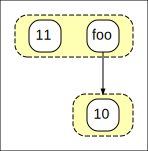

In [27]:
 # https://github.com/egraphs-good/egglog-python/blob/main/docs/reference/bindings.md?plain=1
from egglog import *
egraph = EGraph()
prog = """
(function foo (i64) i64)
(set (foo 10) 11)
"""
# acces to raw bindings via _egraph
commands = egraph._egraph.parse_program(prog)
egraph._egraph.run_program(*commands)
egraph
EGraph.function = lambda self, name: self._egraph.get_function(name)

In [23]:
from egglog.bindings import *
egraph = EGraph()
prog = """
(function foo (i64) i64)
(set (foo 10) 11)
(print-function foo 10)

"""
commands = egraph.parse_program(prog)
egraph.run_program(*commands)

class Expr():
    def __init__(self, name):
        self.name = name
        self.egraph
    def __call__(self, *args):
        return Function(self.name, *args)
    def __repr__(self):
        return f"({self.name} {' '.join(map(repr, self.args))})"
    def __str__(self):
        return repr(self)

class EGraph0(EGraph):
    def function(name, *args):
        return egraph.run_program(*egraph.parse_program(f"(function {name} {' '.join(args)})"))
    def relation(name, *args):
        return egraph.run_program(*egraph.parse_program(f"(relation {name} {' '.join(args)})"))
    def set(*args):
    




['(\n   (foo 10) -> 11\n)\n']

# Fancy Funky Extraction
